# The Three Body Problem  
Using Verlet intergration evolve a 3 body system for position and velocity.  
Calculate angular momentum of the bodies.  
Calculate total energy (potential and kinetic).  
### Verlet  
velocity half step  
$ v_{n+\frac{1}{2}} = v_n +\frac{1}{2} ha (x_n) $  
$ x_{n+1} = x_n +hv_{n+\frac{1}{2}} $  
$ v_{n+1} = v_{n+\frac{1}{2}} +\frac{1}{2} ha (x_{n+1}) $  

$ h $ is timestep  
$ a(x) $ is acceleration at point x. I will calulate using the force function defined near the top, and divide it by mass. So that it in keeping with the other solvers here.

In [1]:
#pip install numpy
#pip install matpoltlib
#pip install scipy
#pip install cycler
#pip install pandas
#pip install timeit

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
#from cycler import cycler
import pandas as pd
import timeit

/tmp/ipykernel_3209/2757466578.py:156: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv("3_body_input_and_tests.txt",delim_whitespace=True)
/tmp/ipykernel_3209/2757466578.py:62: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  rxv = np.cross(p,v)


time taken 354.066575924


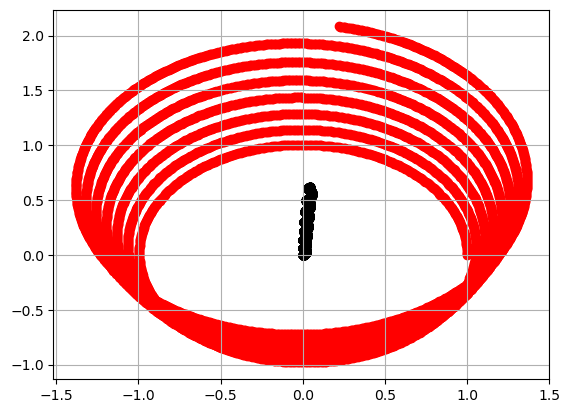

In [ ]:

def Data_save(p, v, E, L, t, f_name):
    """Function for saving positions, velocity, energy and angular momentum produced to a txt file.
    IN:
        p: An array holding all of the positions of that timestep. Cartesain
        v: An array holding all the velocities of that timestep. Cartesain
        E: Total energy of the system
        L: Total angular momentum of the system
        t: Time of the particular step
        f_name: The file the data is being saved to."""
    f = open(f_name, "a")
    f.write("\n" + f"{p[0,0]}" + "\t" + f"{p[0,1]}" + "\t" + f"{p[1,0]}" + "\t" + f"{p[1,1]}")
    f.write("\t" + f"{v[0,0]}" + "\t" + f"{v[0,1]}" + "\t" + f"{v[1,0]}" + "\t" + f"{v[1,1]}")
    f.write("\t" + f"{E}" + "\t" + f"{L}" + "\t" +f"{t}")
    f.close()


def Grav_eng(pos_e, ma_e, pos_other, ma_other, ep, G):
    """Grav_eng(pos_e, ma_e, pos_other, ma_other):
    Calculates tthe gravtiational energy between two bodies.
    U = -GMm/(r+ep)
    IN:
        pos_e: position of the planet in question. [x,y]
        ma_e: mas of the planet in question.
        pos_other: position of the other planet. [x,y]
        ma_other: mas of the other planet.
        ep: extra bit to make sure the numbers dont blow up to much at low distances.
        G: GRavitational constant.
    OUT:
        g_e: gravitational potential energy."""
    
    dif = pos_other-pos_e
    g_e = - (G * ma_e *ma_other) / (np.linalg.norm(dif+ep))

    return g_e

def Kin_eng(vel_e, m_e):
    """Kin_eng(vel_e, m_e):
    Calculate the kinetic energy.
    E = 0.5mv^2
    IN:
        vel_e: velocity of a body. [vx,vy]
        m_e: mass of the planet in question.
    OUT:
        k_e: Kinetic energy of the body."""
    
    k_e = 0.5*m_e*vel_e**2
    k_e = np.linalg.norm(k_e)

    return k_e

def Angular_momentum(p, v, m):
    """Angular_momentum(p, v, m):
    A function which calculates the angular momentum of the system.
    L = r x vm
    IN:
        p: position of the bodies.
        v: velocity of the bodies.
        m: mass of the bodies 
    OUT:
        a_m: total angular momentum for a time step."""

    rxv = np.cross(p,v)
    L = m * rxv
    
    return np.sum(L)

def Force( ma_f, pos_f, ep, G):
    """Force( ma_f, pos_f, ep, G):
    A function for calculating a matricx of the gravitational force between bodies.
    F = GMm/r^2
    IN:
        ma_f: An array of all of the planetary masses.
        pos_f: position of the bodies. [x,y]
        ep: extra bit to make sure the numbers dont blow up to much at low distances.
        G: Gravitational constant.
    OUT:
        mat: a square matrix of the force between the planets"""
    size = len(ma_f)
    mat = np.zeros((size,size), dtype='object')
    mat[:] = 0
    for i in range(size):
        for j in range(size):
            if i==j:
                mat[i,j]=0
            else:
                mx = ma_f[i]
                my = ma_f[j]
                #dif = np.abs(pos[i]-pos[j])
                dif = (pos[i]-pos[j])
                force = - G*mx*my*dif / (np.linalg.norm(dif + ep)**3)
                #print(f" {i},{j} {force}")
                mat[i,j] = mat[i,j]+force
                
    #print(f"force matrix {mat}")
    
    mat = np.sum(mat, axis=1)
    #print(f" force {mat}")
    return mat

def Verlet(pos_v, vel_v, ma, ep, G, t_s):
    """A function that runs a single loop of a verlet integrator.
    IN:
        pos_v: an array holding the positions of all the planets at the beginning of a time step.
        vel_v: an array holding the velocities at the beginning of a time step.
        ma: an array holding the mass of all of the planets.
        ep: extra bit to make sure the numbers dont blow up too much at low distances.
        G: gravitational constant.
        t_s: time step.

    OUT:
        pos_full: an array holding the position of all the bodies at the end of a time step
        vel_full: an array holding the velocities of all the bodies at the end of a time step
    """

    pos_full = np.array([])
    vel_full = np.array([])
    vel_half = np.array([])  # NEW: Store half-step velocities
    kinetic = np.array([])
    gravitational = np.array([])
    f_half = Force(ma_f=ma, pos_f=pos_v, ep=ep, G=G)

    # Calculate half-step velocities and full-step positions
    for v in range(len(ma)):
        v_h = vel_v[v] + (0.5 * t_s * f_half[v]/ma[v])
        p_full = pos_v[v] + (t_s * v_h)
        
        # Store half-step velocity
        if vel_half.shape == (0,):
            vel_half = np.array([v_h])
        else:
            vel_half = np.vstack((vel_half, np.array([v_h])))
        
        if pos_full.shape == (0,):
            pos_full = np.array([p_full])
        else:
            pos_full = np.vstack((pos_full, np.array([p_full])))

    f_full = Force(ma_f=ma, pos_f=pos_full, ep=ep, G=G)

    # Calculate full-step velocities using stored half-step velocities
    for ve in range(len(ma)):
        v_full = vel_half[ve] + (0.5 * t_s * f_full[ve]/ma[ve])
        
        if vel_full.shape == (0,):
            vel_full = np.array([v_full])
        else:
            vel_full = np.vstack((vel_full, np.array([v_full])))
      
        kinetic = np.append(kinetic, Kin_eng(v_full, ma[ve]))
        gravitational = np.append(gravitational, Grav_eng(pos_full[ve], ma[ve], pos_full, ma, ep, G))

    kinetic = np.sum(kinetic)
    gravitational = np.sum(gravitational)
    return pos_full, vel_full, gravitational, kinetic

data = pd.read_csv("3_body_input_and_tests.txt",delim_whitespace=True)
initial = 0
in_con = data.iloc[initial]

masses = np.array([in_con.loc["m1"], in_con.loc["m2"], in_con.loc["m3"]])
i_positions = np.array([[in_con.loc["pos1x"],in_con.loc["pos1y"]], [in_con.loc["pos2x"],in_con.loc["pos2y"]], [in_con.loc["pos3x"],in_con.loc["pos3y"]]])
i_velocities = np.array([[in_con.loc["vel1x"],in_con.loc["vel1y"]], [in_con.loc["vel2x"],in_con.loc["vel2y"]], [in_con.loc["vel3x"],in_con.loc["vel3y"]]])

for i in range(len(masses)):
    if masses[i] == 0:
        masses = np.delete(masses, i)
        i_positions = np.delete(i_positions, i, 0)
        i_velocities = np.delete(i_velocities, i, 0)


fin = 6
time_step = 0.001
no_steps = round(fin/time_step)
epsilon = 0.001
G = 1

file_name = f"produced_data_system_{0}.txt"
file = open(file_name, "w")

for a in range(len(masses)):
    #file.write("px1" + "\t" + "p1y" + "\t" + "p2x" + "\t" + "p2y" + "\t" + "p3x" + "\t" + "p3y" + "\t" + "vx1" + "\t" + "v1y" + "\t" + "v2x" + "\t" + "v2y" + "\t" + "v3x" + "\t" + "v3y" + "\t" + "Energy" + "\t" + "ang_mom")
    file.write(f"p{a+1}x" + "\t" + f"p{a+1}y" + "\t")
    
for a in range(len(masses)):
    file.write(f"v{a+1}x" + "\t" + f"v{a+1}y" + "\t")

file.write("Energy" + "\t" + "Ang_mom" + "\t" + "time")
    
file.close()


pos = i_positions
vel = i_velocities
fig =  plt.figure()
ax = fig.add_subplot()
fig_E_L, ax_E_L = plt.subplots(1,2)
ax_E_L[0].set_title("Energy")
ax_E_L[1].set_title("Angular Momentum")
tot_eng=0
ang_mom=0

t1 = timeit.default_timer()
for i in range(no_steps):
    #print(f"pos {pos[0]}")
    ax.scatter(pos[0,0], pos[0,1], color = "k")
    ax.scatter(pos[1,0] ,pos[1,1], color = "red")
    #ax.scatter(pos[2,0] ,pos[2,1], color = "blue")
    time = i *time_step

    
    
    Data_save(p=pos, v=vel, E=tot_eng, L=ang_mom, t=time, f_name = file_name)


    new_pos, new_vel, gravitational_energy, kinetic_energy = Verlet(pos_v=pos, vel_v=vel, ma=masses, ep=epsilon, G=G, t_s=time_step)     #Calling verlet intergrator

    ang_mom = Angular_momentum(p = new_pos, v = new_vel, m = masses)
    tot_eng = kinetic_energy + np.sum(gravitational_energy)
    ax_E_L[0].scatter(time,tot_eng, color = "Green")
    ax_E_L[1].scatter(time,ang_mom, color = "Blue")
    
    #print(new_pos)
    #print(f"vel-new_vel {vel-new_vel}")
    pos = new_pos
    vel = new_vel

ax.grid(True)
    
t2 = timeit.default_timer()
print(f"time taken {t2-t1}")



In [ ]:
ax.set_xlim(-2.5,2.5)
ax.set_ylim(-2.5,2.5)
fig

In [ ]:
fig_E_L